### Citibike Analysis

In [171]:
import os
from dotenv import load_dotenv

from google.cloud import bigquery
from google.api_core.exceptions import NotFound, BadRequest


import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import f_oneway


In [3]:
load_dotenv()

True

In [4]:
client = bigquery.Client()

bq_project_id = os.getenv('GCP_PROJECT_ID')
bq_dataset_name = os.getenv('BQ_DATASET')
bq_table_name = os.getenv('BQ_TABLE')

table_red = f'{bq_project_id}.{bq_dataset_name}.{bq_table_name}'
cleaned_table_ref = f'{bq_project_id}.{bq_dataset_name}.{bq_table_name}_cleaned'

In [5]:
query = f"""
    SELECT *
    FROM `{bq_dataset_name}.{bq_table_name}`
    LIMIT 5
"""

df = client.query(query).to_dataframe()
df

/home/olshe/pers/eu-climate-economic-resilience/.venv/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1957: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,cleaned_start_station_id,cleaned_start_station_name
0,5F2C4BF56F666C5D,classic_bike,2025-01-18 12:03:54.379000+00:00,2025-01-18 12:25:06.024000+00:00,67 St & Erik Pl,2733.03,67 St & Erik Pl,2733.03,40.633385,-74.016562,40.633385,-74.016562,member,None,None
1,3C13D8C8B3591766,classic_bike,2025-01-31 07:37:41.422000+00:00,2025-01-31 07:39:26.664000+00:00,67 St & Erik Pl,2733.03,5 Ave & 67 St,2782.02,40.633385,-74.016562,40.635679,-74.020005,member,None,None
2,DA8DDEFF2C595EBE,classic_bike,2025-01-13 16:38:45.027000+00:00,2025-01-13 16:40:20.083000+00:00,67 St & Erik Pl,2733.03,5 Ave & 67 St,2782.02,40.633385,-74.016562,40.635679,-74.020005,member,None,None
3,234A36BC8E7A629B,classic_bike,2025-01-22 08:03:27.502000+00:00,2025-01-22 08:09:56.667000+00:00,67 St & Erik Pl,2733.03,55 St & 7 Ave,2951.05,40.633385,-74.016562,40.639673,-74.008957,member,None,None
4,E58C6DBAF75793E3,classic_bike,2025-01-28 22:19:46.463000+00:00,2025-01-28 22:24:47.685000+00:00,67 St & Erik Pl,2733.03,59 St & 4 Ave,3011.03,40.633385,-74.016562,40.641269,-74.017651,member,None,None


In [6]:
df.columns

Index(['ride_id', 'rideable_type', 'started_at', 'ended_at',
       'start_station_name', 'start_station_id', 'end_station_name',
       'end_station_id', 'start_lat', 'start_lng', 'end_lat', 'end_lng',
       'member_casual', 'cleaned_start_station_id',
       'cleaned_start_station_name'],
      dtype='object')

In [7]:
df.dtypes

ride_id                                    object
rideable_type                              object
started_at                    datetime64[us, UTC]
ended_at                      datetime64[us, UTC]
start_station_name                         object
start_station_id                           object
end_station_name                           object
end_station_id                             object
start_lat                                 float64
start_lng                                 float64
end_lat                                   float64
end_lng                                   float64
member_casual                              object
cleaned_start_station_id                   object
cleaned_start_station_name                 object
dtype: object

In [8]:
query = f"""
    SELECT 
        COUNT(*) - COUNT(ride_id) as ride_id_null,
        COUNT(*) - COUNT(rideable_type) as rideable_type_null,
        COUNT(*) - COUNT(started_at) as started_at_null,
        COUNT(*) - COUNT(ended_at) as ended_at_null,
        COUNT(*) - COUNT(start_station_name) as start_station_name_null,
        COUNT(*) - COUNT(start_station_id) as start_station_idnull,
        COUNT(*) - COUNT(end_station_name) as end_station_name_null,
        COUNT(*) - COUNT(end_station_id) as end_station_id_null,
        COUNT(*) - COUNT(start_lat) as start_lat_null,
        COUNT(*) - COUNT(start_lng) as start_lng_null,
        COUNT(*) - COUNT(end_lat) as end_lat_null,
        COUNT(*) - COUNT(end_lng) as end_lng_null,
        COUNT(*) - COUNT(member_casual) as member_casual_null
    FROM `{bq_dataset_name}.{bq_table_name}`
"""

df = client.query(query).to_dataframe()
df

/home/olshe/pers/eu-climate-economic-resilience/.venv/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1957: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


,ride_id_null,rideable_type_null,started_at_null,ended_at_null,start_station_name_null,start_station_idnull,end_station_name_null,end_station_id_null,start_lat_null,start_lng_null,end_lat_null,end_lng_null,member_casual_null
0,0,0,0,0,35253,0,152745,0,0,0,12784,12784,0


In [9]:
query = f"""
    SELECT *
    FROM `{bq_dataset_name}.{bq_table_name}`
    WHERE start_station_name IS NULL
    LIMIT 5
"""

df = client.query(query).to_dataframe()
df

/home/olshe/pers/eu-climate-economic-resilience/.venv/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1957: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,cleaned_start_station_id,cleaned_start_station_name
0,16A4ED1505A13D3F,electric_bike,2024-11-14 17:08:17.899000+00:00,2024-11-14 17:25:05.339000+00:00,None,nan,Cortelyou Rd & Argyle Rd,2984.04,40.65,-74.00,40.640340,-73.966030,casual,None,None
1,22C85C606F5AB7D9,electric_bike,2024-11-22 15:32:45.958000+00:00,2024-11-22 16:38:04.567000+00:00,None,nan,6 Ave & 55 St,3000.08,40.65,-74.00,40.640831,-74.010996,casual,None,None
2,45EA3047CCF80C62,electric_bike,2024-11-01 15:34:43.628000+00:00,2024-11-01 15:37:25.117000+00:00,None,nan,52 St & 1 Ave,3253.01,40.64,-74.01,40.649292,-74.020105,casual,None,None
3,53B34B319E2D816E,electric_bike,2024-11-14 17:11:04.328000+00:00,2024-11-14 17:42:04.710000+00:00,None,nan,Rutland Rd & E 45 St,3567.05,40.71,-73.99,40.660340,-73.936180,casual,None,None
4,276E868605E242F1,electric_bike,2024-11-18 15:18:59.364000+00:00,2024-11-18 16:00:02.779000+00:00,None,nan,Maple St & Albany Ave,3608.06,40.66,-73.94,40.661550,-73.939740,casual,None,None


In [10]:
query = f"""
    SELECT *
    FROM `{bq_dataset_name}.{bq_table_name}`
    WHERE end_station_name IS NULL
    LIMIT 5
"""

df = client.query(query).to_dataframe()
df

/home/olshe/pers/eu-climate-economic-resilience/.venv/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1957: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,cleaned_start_station_id,cleaned_start_station_name
0,CBCD3C72559F2B35,classic_bike,2024-10-31 20:44:44.600000+00:00,2024-11-01 21:44:40.324000+00:00,Cortelyou Rd & Stratford Rd,2898.01,None,nan,40.639660,-73.968070,NaN,NaN,casual,None,None
1,96FBB4087820A30D,classic_bike,2024-10-01 21:40:32.149000+00:00,2024-10-02 22:40:27.657000+00:00,Cortelyou Rd & Argyle Rd,2984.04,None,nan,40.640340,-73.966030,NaN,NaN,casual,None,None
2,0F53580F22942FDD,classic_bike,2024-10-19 23:10:16.652000+00:00,2024-10-21 00:10:12.738000+00:00,Cortelyou Rd & E 19 St,3022.01,None,nan,40.642690,-73.960990,NaN,NaN,casual,None,None
3,99F43D2EEB247081,classic_bike,2024-10-07 08:48:29.391000+00:00,2024-10-08 09:48:26.494000+00:00,12 Ave & 36 St,3056.05,None,nan,40.643546,-73.986418,NaN,NaN,casual,None,None
4,FDDFF503BA08BEAF,classic_bike,2024-10-15 16:42:28.311000+00:00,2024-10-16 17:42:22.984000+00:00,Beverley Rd & Flatbush Ave,3180.02,None,nan,40.644990,-73.958180,NaN,NaN,casual,None,None


In [11]:
query = f"""
    SELECT COUNT(*) as cnt
    FROM `{bq_dataset_name}.{bq_table_name}`
    WHERE start_station_id = 'nan' OR end_station_id = 'nan'
"""

nan_cnt = client.query(query).to_dataframe()['cnt'][0]
nan_cnt

/home/olshe/pers/eu-climate-economic-resilience/.venv/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1957: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


np.int64(182206)

In [12]:
query = f"""
    CREATE OR REPLACE TABLE {cleaned_table_ref}
    PARTITION BY DATE_TRUNC(started_at, MONTH)
    CLUSTER BY member_casual, rideable_type 
        AS
            SELECT * FROM `{bq_dataset_name}.{bq_table_name}`
            WHERE start_station_id != 'nan' AND end_station_id != 'nan'
"""

job = client.query(query)
job.result()


In [13]:
query = f"""
    SELECT COUNT(*) as cnt
    FROM {cleaned_table_ref}
    WHERE start_station_id = 'nan' OR end_station_id = 'nan'
"""

nan_cnt = client.query(query).to_dataframe()['cnt'][0]
nan_cnt

np.int64(0)

In [104]:
query = f"""
    SELECT *
    FROM {cleaned_table_ref}
    WHERE TIMESTAMP_DIFF(ended_at, started_at, MINUTE) <= 0
    
"""

casual_classic_time = client.query(query).to_dataframe()
casual_classic_time.head()

/home/olshe/pers/eu-climate-economic-resilience/.venv/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1957: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,cleaned_start_station_id,cleaned_start_station_name


In [105]:
query = f"""
 SELECT
  COUNT(*) AS total_trips,
  AVG(TIMESTAMP_DIFF(ended_at, started_at, MINUTE)) AS avg_ride_time,
  -- approximate median as 50th percentile
  APPROX_QUANTILES(TIMESTAMP_DIFF(ended_at, started_at, MINUTE), 100)[OFFSET(50)] AS median_ride_time,
  COUNTIF(TIMESTAMP_DIFF(ended_at, started_at, MINUTE) > 45) AS trips_over_45_min,
  COUNTIF(TIMESTAMP_DIFF(ended_at, started_at, MINUTE) > 120) AS trips_over_2_hours,
  ROUND(100 * COUNTIF(TIMESTAMP_DIFF(ended_at, started_at, MINUTE) > 45) / COUNT(*), 2) AS pct_over_45_min,
  ROUND(100 * COUNTIF(TIMESTAMP_DIFF(ended_at, started_at, MINUTE) > 120) / COUNT(*), 2) AS pct_over_2_hours
FROM
  {cleaned_table_ref}
WHERE
  ended_at IS NOT NULL
  AND started_at IS NOT NULL
"""

df =  client.query(query).to_dataframe()
df

/home/olshe/pers/eu-climate-economic-resilience/.venv/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1957: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


,total_trips,avg_ride_time,median_ride_time,trips_over_45_min,trips_over_2_hours,pct_over_45_min,pct_over_2_hours
0,59483258,12.045067,8,1127097,101822,1.89,0.17


In [177]:
query = f"""
    DELETE
    FROM {cleaned_table_ref}
    WHERE 
        TIMESTAMP_DIFF(ended_at, started_at, MINUTE) < 2 
    OR 
        TIMESTAMP_DIFF(ended_at, started_at, MINUTE) > 120
"""

job = client.query(query)
job.result()

In [14]:
query = f"""
    SELECT start_station_id, COUNT(*)
    FROM {cleaned_table_ref}
    WHERE start_station_id IS NULL OR SAFE_CAST(start_station_id AS FLOAT64) IS NULL
    GROUP BY start_station_id;
"""

df = client.query(query).to_dataframe()
df

,start_station_id,f0_
0,JC104,4
1,HB602,6
2,JC018,1
3,JC102,1
4,JC080,4
...,...,...
72,HB202,3
73,JC098,1
74,JC105,4
75,JC022,2


In [15]:
regex = r'^[A-Za-z]{2}\d{3}$'

query = f"""
    DELETE 
    FROM {cleaned_table_ref}
    WHERE REGEXP_CONTAINS(start_station_id, r'{regex}') OR REGEXP_CONTAINS(end_station_id, r'{regex}')
"""

job = client.query(query)
job.result()

In [16]:
query = f"""
    SELECT start_station_id, COUNT(*)
    FROM {cleaned_table_ref}
    WHERE start_station_id IS NULL OR SAFE_CAST(start_station_id AS FLOAT64) IS NULL
    GROUP BY start_station_id;
"""

df = client.query(query).to_dataframe()
df

/home/olshe/pers/eu-climate-economic-resilience/.venv/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1957: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


,start_station_id,f0_
0,6247.06_Pillar,70
1,LA Metro Demo 2,12
2,SYS038,1219
3,Lab - NYC,6
4,5308.04_,44
5,LA Metro Demo 1,4
6,190 Morgan,5
7,Shop Morgan,1023
8,Lab - NYC - Monolith,8
9,SYS033,156


In [17]:
regex_patterns = [
    r'^SYS\d{3}$',          # SYS + 3 digits
    r'(?i)Demo',            # Contains "Demo"
    r'(?i)Lab - NYC',       # Contains "Lab - NYC"
    r'(?i)Morgan'           # Contains "Morgan"
]

combined_pattern = '|'.join(regex_patterns)

query = f"""
    DELETE FROM {cleaned_table_ref}
    WHERE REGEXP_CONTAINS(start_station_id, r'{combined_pattern}') OR REGEXP_CONTAINS(end_station_id, r'{combined_pattern}')
"""

job = client.query(query)
job.result()

In [18]:
regex = r'^\d+\.\d+_$'

query = f"""
    UPDATE {cleaned_table_ref}
    SET 
        start_station_id = CASE 
            WHEN REGEXP_CONTAINS(start_station_id, r'{regex}') THEN REPLACE(start_station_id, '_', '')
            ELSE start_station_id
        END,
        end_station_id = CASE 
            WHEN REGEXP_CONTAINS(end_station_id, r'{regex}') THEN REPLACE(end_station_id, '_', '')
            ELSE end_station_id
        END
    WHERE 
        REGEXP_CONTAINS(start_station_id, r'{regex}') OR
        REGEXP_CONTAINS(end_station_id, r'{regex}')
"""

job = client.query(query)
job.result()

In [19]:
regex_id = r'_Pillar$'
regex_name = r'(?i)\s*Pillar\s*'

query = f"""
    UPDATE {cleaned_table_ref}
    SET 
        start_station_id = CASE 
            WHEN REGEXP_CONTAINS(start_station_id, r'Pillar') THEN REGEXP_REPLACE(start_station_id, r'{regex_id}', '') 
            ELSE start_station_id END,
        start_station_name = CASE 
            WHEN REGEXP_CONTAINS(start_station_name, r'Pillar') THEN TRIM(REGEXP_REPLACE(start_station_name, r'{regex_name}', ' ')) 
            ELSE start_station_name END,
        end_station_id = CASE 
            WHEN REGEXP_CONTAINS(end_station_id, r'Pillar') THEN REGEXP_REPLACE(end_station_id, r'{regex_id}', '') 
            ELSE end_station_id END,
        end_station_name = CASE 
            WHEN REGEXP_CONTAINS(end_station_name, r'Pillar') THEN TRIM(REGEXP_REPLACE(end_station_name, r'{regex_name}', ' ')) 
            ELSE end_station_name END
        WHERE 
            REGEXP_CONTAINS(start_station_id, r'Pillar') OR
            REGEXP_CONTAINS(start_station_name, r'Pillar') OR
            REGEXP_CONTAINS(end_station_id, r'Pillar') OR
            REGEXP_CONTAINS(end_station_name, r'Pillar')
"""

job = client.query(query)
job.result()


In [20]:
query = f"""
    SELECT start_station_name, start_station_id, COUNT(*)
    FROM `{cleaned_table_ref}`
    WHERE start_station_id IS NULL OR SAFE_CAST(start_station_id AS FLOAT64) IS NULL
    GROUP BY start_station_name, start_station_id;
"""

df = client.query(query).to_dataframe()
df

/home/olshe/pers/eu-climate-economic-resilience/.venv/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1957: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


,start_station_name,start_station_id,f0_


In [21]:
query = f"""
    SELECT end_station_name, end_station_id, COUNT(*)
    FROM `{cleaned_table_ref}`
    WHERE end_station_id IS NULL OR SAFE_CAST(end_station_id AS FLOAT64) IS NULL
    GROUP BY end_station_name, end_station_id;
"""

df = client.query(query).to_dataframe()
df

/home/olshe/pers/eu-climate-economic-resilience/.venv/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1957: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


,end_station_name,end_station_id,f0_


In [22]:
query = f"""
    SELECT start_station_name, start_station_id
    FROM {cleaned_table_ref}
    GROUP BY start_station_name, start_station_id
"""

df = client.query(query).to_dataframe()
df[df['start_station_id'].duplicated(keep=False)].sort_values(by='start_station_id')

/home/olshe/pers/eu-climate-economic-resilience/.venv/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1957: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


,start_station_name,start_station_id
194,Eastern Pkwy\t& St Marks Ave,3982.01
675,Eastern Pkwy & St Marks Ave,3982.01
1562,Bridge St & Water St,4968.03
421,Bridge St & Front St,4968.03
2327,Metropolitan Ave & Bedford Ave,5308.04
1948,Metropolitan Ave & Bedford Ave,5308.04
280,Morton St & Greenwich St,5772.05
470,Morton St & Washington St,5772.05
1876,34th Ave & Vernon Blvd,6873.01
1227,34 Ave & Vernon Blvd,6873.01


In [23]:
regex = r'^\d+\.\d{2}$'

query = f"""
    UPDATE {cleaned_table_ref}
    SET start_station_id = CAST(FORMAT('%.2f', CAST(start_station_id AS FLOAT64)) AS STRING),
        end_station_id = CAST(FORMAT('%.2f', CAST(end_station_id AS FLOAT64)) AS STRING)
    WHERE NOT REGEXP_CONTAINS(start_station_id, r'{regex}') OR NOT REGEXP_CONTAINS(end_station_id, r'{regex}')
"""
job = client.query(query)
job.result()

In [24]:
convert_names = {
    'West': 'W',
    'Fort': 'Ft',
    'Av': 'Ave',
    'Ichan Stadium': 'Icahn Stadium'
}

sql_expr_start = "start_station_name"
for old, new in convert_names.items():
    sql_expr_start = f"REGEXP_REPLACE({sql_expr_start}, r'\\b{old}\\b', '{new}')"

sql_expr_end = "end_station_name"
for old, new in convert_names.items():
    sql_expr_end = f"REGEXP_REPLACE({sql_expr_end}, r'\\b{old}\\b', '{new}')"

conditions = []
for old, new in convert_names.items():
    conditions.append(f"start_station_name LIKE '%{old}%' OR end_station_name LIKE '%{old}%'")
clause = ' OR '.join(conditions)

query = f"""
    UPDATE {cleaned_table_ref}
    SET start_station_name = {sql_expr_start},
        end_station_name = {sql_expr_end}
    WHERE {clause}
"""

job = client.query(query)
job.result()

In [25]:
pattern = r'\\t'

query = f"""
    UPDATE {cleaned_table_ref}
    SET start_station_name = REGEXP_REPLACE(start_station_name, r'{pattern}', ' '),
        end_station_name = REGEXP_REPLACE(end_station_name, r'{pattern}', ' ')
    WHERE REGEXP_CONTAINS(start_station_name, r'{pattern}') OR REGEXP_CONTAINS(end_station_name, r'{pattern}')
"""

job = client.query(query)
job.result()

In [26]:
pattern = r'(\d+)(st|nd|rd|th)\b'
replace = r'\1'

query = f"""
    UPDATE {cleaned_table_ref}
    SET start_station_id = REGEXP_REPLACE(start_station_name, r'{pattern}', r'{replace}'),
        end_station_name = REGEXP_REPLACE(end_station_name, r'{pattern}', r'{replace}')
    WHERE REGEXP_CONTAINS(start_station_name, r'{pattern}') OR REGEXP_CONTAINS(end_station_name, r'{pattern}')
"""

job = client.query(query)
job.result()

In [27]:
query = f"""
    SELECT end_station_name, end_station_id, COUNT(*)
    FROM {cleaned_table_ref}
    GROUP BY end_station_name, end_station_id
"""

df = client.query(query).to_dataframe()
df[df['end_station_id'].duplicated(keep=False)].sort_values(by='end_station_id')

/home/olshe/pers/eu-climate-economic-resilience/.venv/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1957: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


,end_station_name,end_station_id,f0_
1336,Bridge St & Water St,4968.03,27593
1953,Bridge St & Front St,4968.03,19473
163,Metropolitan Ave & Bedford Ave,5308.04,135516
2085,Metropolitan Ave & Bedford Ave,5308.04,45
1038,Morton St & Greenwich St,5772.05,39385
1741,Morton St & Washington St,5772.05,31182
863,3 Ave & E 81 St,7154.10,21866
1170,3 Ave & E 82 St,7154.10,41780


In [28]:
convert_names = {
    'Bridge St & Water St': 'Bridge St & Front St',
    'Morton St & Washington St': 'Morton St & Greenwich St',
    '3 Ave & E 81 St': '3 Ave & E 82 St'
}

case_statements_start = []
for old, new in convert_names.items():
    case_statements_start.append(f"WHEN start_station_name = '{old}' THEN '{new}'")

case_statements_end = []
for old, new in convert_names.items():
    case_statements_end.append(f"WHEN end_station_name = '{old}' THEN '{new}'")

query = f"""
    UPDATE {cleaned_table_ref}
    SET start_station_name = CASE {' '.join(case_statements_start)} ELSE start_station_name END,
        end_station_name = CASE {' '.join(case_statements_end)} ELSE end_station_name END
    WHERE start_station_name IN ({', '.join(f"'{old}'" for old in convert_names.keys())}) OR end_station_name IN ({', '.join(f"'{old}'" for old in convert_names.keys())})
"""

job = client.query(query)
job.result()

In [29]:
query = f"""
    SELECT start_station_name, start_station_id, COUNT(*)
    FROM {cleaned_table_ref}
    GROUP BY start_station_name, start_station_id
"""

df = client.query(query).to_dataframe()
df[df['start_station_id'].duplicated(keep=False)].sort_values(by='start_station_id')

/home/olshe/pers/eu-climate-economic-resilience/.venv/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1957: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


,start_station_name,start_station_id,f0_
1502,Metropolitan Ave & Bedford Ave,5308.04,44
2391,Metropolitan Ave & Bedford Ave,5308.04,134469


In [30]:
regex = r'^\s+|\s+$|\s{2,}'

query = f"""
    UPDATE {cleaned_table_ref}
    SET start_station_name = REGEXP_REPLACE(TRIM(start_station_name), r'\s+', ' '),
        end_station_name = REGEXP_REPLACE(TRIM(end_station_name), r'\s+', ' ')
    WHERE REGEXP_CONTAINS(start_station_name, r'{regex}') OR REGEXP_CONTAINS(end_station_name, r'{regex}')
"""

job = client.query(query)
job.result()

<>:8: SyntaxWarning: invalid escape sequence '\s'
<>:8: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_25653/1715883286.py:8: SyntaxWarning: invalid escape sequence '\s'
  """


In [31]:
query = f"""
    SELECT end_station_name, end_station_id, COUNT(*)
    FROM {cleaned_table_ref}
    GROUP BY end_station_name, end_station_id
"""

df = client.query(query).to_dataframe()
df[df['end_station_id'].duplicated(keep=False)].sort_values(by='end_station_id')

/home/olshe/pers/eu-climate-economic-resilience/.venv/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1957: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


,end_station_name,end_station_id,f0_


In [ ]:
table = client.get_table(cleaned_table_ref)
schema = table.schema
new_columns = [
    bigquery.SchemaField("day_of_week", "STRING", mode="NULLABLE"),
    bigquery.SchemaField("ride_time", "FLOAT", mode="NULLABLE")
]

new_schema = schema[:] + new_columns
table.schema = new_schema

job = client.update_table(table, ['schema'])
job.result()

In [187]:
query = f"""
    UPDATE {cleaned_table_ref}
    SET day_of_week = 
        CASE EXTRACT(DAYOFWEEK FROM started_at) 
            WHEN 1 THEN 'Sunday'
            WHEN 2 THEN 'Monday' 
            WHEN 3 THEN 'Tuesday'
            WHEN 4 THEN 'Wednesday'
            WHEN 5 THEN 'Thursday'
            WHEN 6 THEN 'Friday'
            WHEN 7 THEN 'Saturday'
        END,
        ride_time = TIMESTAMP_DIFF(ended_at, started_at, MINUTE)
    WHERE TRUE
"""

job = client.query(query)
job.result()

# Main Part

In [218]:
query = f"""
    SELECT start_station_name, AVG(ride_time) as ride_time
    FROM {cleaned_table_ref}
    GROUP BY start_station_name
    ORDER BY ride_time DESC
    LIMIT 10
"""

df_start_station = client.query(query).to_dataframe()
df_start_station

/home/olshe/pers/eu-climate-economic-resilience/.venv/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1957: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


,start_station_name,ride_time
0,Soissons Landing,33.819884
1,Yankee Ferry Terminal,31.236559
2,65 St & 2 Ave,30.028192
3,Dyckman St & Henshaw St,29.047288
4,Dyckman St & Staff St,28.747987
5,Central Park S & 6 Ave,25.603196
6,Southpoint Park,25.216732
7,Shea Rd & Boat Basin Pl,25.088361
8,Broadway & Van Cortlandt Park S,25.078442
9,W 181 St & Riverside Dr,25.042431


In [221]:
query = f"""
    SELECT end_station_name, AVG(ride_time) as ride_time, COUNT(*) as cnt
    FROM {cleaned_table_ref}
    GROUP BY end_station_name
    ORDER BY cnt DESC
    LIMIT 100
"""

df_end_station = client.query(query).to_dataframe()
df_end_station

/home/olshe/pers/eu-climate-economic-resilience/.venv/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1957: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


,end_station_name,ride_time,cnt
0,W 21 St & 6 Ave,9.165918,217806
1,University Pl & E 14 St,9.364429,182779
2,Lafayette St & E 8 St,9.505527,179757
3,8 Ave & W 31 St,10.878559,178580
4,W St & Chambers St,16.039814,177775
...,...,...,...
95,W 44 St & 11 Ave,12.225392,96645
96,Broadway & W 61 St,14.189896,96263
97,E 40 St & 5 Ave,12.330688,96021
98,E 20 St & FDR Dr,9.891776,95413


In [23]:
start_end_count = pd.merge(left=df_start_station, right=df_end_station, how='outer', left_on='start_station_name', right_on='end_station_name')
start_end_count

,start_station_name,cnt_start,end_station_name,cnt_end
0,11 Ave & W 41 St,171353,11 Ave & W 41 St,171131
1,8 Ave & W 31 St,180308,8 Ave & W 31 St,181875
2,Broadway & E 14 St,172633,Broadway & E 14 St,171544
3,Broadway & W 25 St,161784,Broadway & W 25 St,162670
4,Broadway & W 58 St,178598,Broadway & W 58 St,176405
5,Lafayette St & E 8 St,183811,Lafayette St & E 8 St,184606
6,University Pl & E 14 St,184610,University Pl & E 14 St,187290
7,W 21 St & 6 Ave,221700,W 21 St & 6 Ave,222436
8,W 31 St & 7 Ave,176406,W 31 St & 7 Ave,176768
9,W St & Chambers St,180794,W St & Chambers St,182143


In [27]:
start_end_count['total'] = start_end_count['cnt_start'] + start_end_count['cnt_end']
start_end_count.sort_values(by='total', ascending=False).iloc[0].loc['start_station_name']

'W 21 St & 6 Ave'

In [15]:
query = f"""
    SELECT start_station_name, end_station_name, COUNT(*) as cnt
    FROM {cleaned_table_ref}
    GROUP BY start_station_name, end_station_name
    ORDER BY cnt DESC
    LIMIT 10
"""

df = client.query(query).to_dataframe()
df

/home/olshe/pers/eu-climate-economic-resilience/.venv/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1957: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


,start_station_name,end_station_name,cnt
0,Central Park S & 6 Ave,Central Park S & 6 Ave,20502
1,7 Ave & Central Park South,7 Ave & Central Park South,17046
2,Roosevelt Island Tramway,Roosevelt Island Tramway,11419
3,W 21 St & 6 Ave,9 Ave & W 22 St,8358
4,River Ter & Warren St,Vesey Pl & River Terrace,8334
5,Norfolk St & Broome St,Henry St & Grand St,8244
6,Broadway & W 58 St,Broadway & W 58 St,8058
7,Henry St & Grand St,Norfolk St & Broome St,7848
8,55 Ave & Center Blvd,Vernon Blvd & 50 Ave,7643
9,Roosevelt Island Tramway,Motorgate,7434


In [28]:
query = f"""
    SELECT start_station_name, COUNT(*) as cnt_start
    FROM {cleaned_table_ref}
    GROUP BY start_station_name
    ORDER BY cnt_start ASC
    LIMIT 10
"""

df_start_station = client.query(query).to_dataframe()
df_start_station

/home/olshe/pers/eu-climate-economic-resilience/.venv/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1957: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


,start_station_name,cnt_start
0,Creston Ave & E 181 St,27
1,Ryer Ave & E 182 St,35
2,Morris Ave & E 184 St,42
3,Creston Ave & E 178 St,51
4,2 Ave & 39 St,81
5,E 118 St & 1 Ave,160
6,W Burnside Ave & University Ave,199
7,20 Ave & 21 St,374
8,2 Ave & 43 St,397
9,E New York Ave & Utica Ave,447


In [29]:
query = f"""
    SELECT end_station_name, COUNT(*) as cnt_start
    FROM {cleaned_table_ref}
    GROUP BY end_station_name
    ORDER BY cnt_start ASC
    LIMIT 10
"""

df_start_station = client.query(query).to_dataframe()
df_start_station

/home/olshe/pers/eu-climate-economic-resilience/.venv/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1957: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


,end_station_name,cnt_start
0,Creston Ave & E 181 St,25
1,Ryer Ave & E 182 St,33
2,Morris Ave & E 184 St,41
3,Creston Ave & E 178 St,49
4,2 Ave & 39 St,84
5,E 118 St & 1 Ave,172
6,W Burnside Ave & University Ave,200
7,20 Ave & 21 St,334
8,2 Ave & 43 St,409
9,E New York Ave & Utica Ave,471


/home/olshe/pers/eu-climate-economic-resilience/.venv/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1957: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


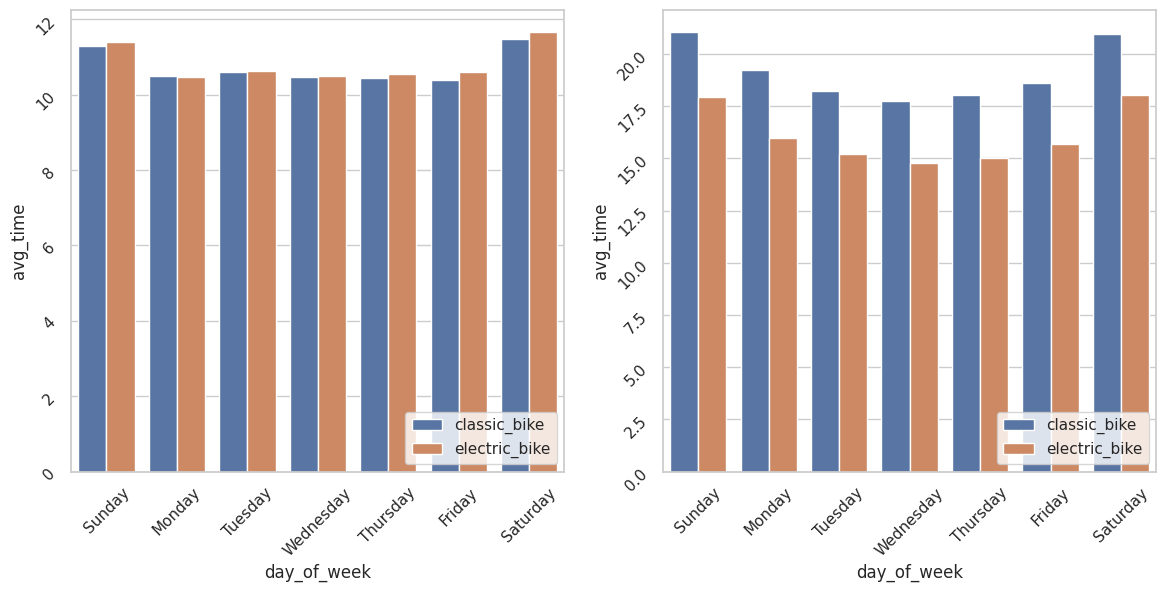

In [ ]:
query = f"""
    SELECT 
        member_casual,
        rideable_type,
        day_of_week, 
        AVG(ride_time) as avg_time
        FROM {cleaned_table_ref}
    GROUP BY member_casual, rideable_type, day_of_week
"""

df = client.query(query).to_dataframe()

custom_dict = {'Sunday': 0, 'Monday': 1, 'Tuesday': 2, 'Wednesday': 3, 'Thursday': 4, 'Friday': 5, 'Saturday': 6} 
df = df.sort_values(by='day_of_week', key=lambda x: x.map(custom_dict))

member_df = df[df['member_casual'] == 'member']
casual_df = df[df['member_casual'] == 'casual']

fig, ax = plt.subplots(1,2, figsize=(14, 6))

sns.barplot(data=member_df, x='day_of_week', y='avg_time', hue='rideable_type', ax=ax[0])
sns.barplot(data=casual_df, x='day_of_week', y='avg_time', hue='rideable_type', ax=ax[1])

ax[0].tick_params(labelrotation=45)
ax[0].legend(loc='lower right')

ax[1].tick_params(labelrotation=45)
ax[1].legend(loc='lower right')

In [211]:
query = f"""
    WITH ranked as (
        SELECT *, ROW_NUMBER() OVER (PARTITION BY member_casual, day_of_week ORDER BY ride_id) AS rn
        FROM {cleaned_table_ref}
    )

    SELECT * 
    FROM ranked
    WHERE rn <= 15000

"""

df = client.query(query).to_dataframe()

member_by_day = df[df['member_casual'] == 'member']
casual_by_day = df[df['member_casual'] == 'casual']

/home/olshe/pers/eu-climate-economic-resilience/.venv/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1957: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


In [213]:
member_groups = [group['ride_time'].values for _, group in member_by_day.groupby('day_of_week')]
casual_groups = [group['ride_time'].values for _, group in casual_by_day.groupby('day_of_week')]

f_stat_member, p_val_member = f_oneway(*member_groups)
f_stat_casual, p_val_casual = f_oneway(*casual_groups)

print("Member users: F =", f_stat_member, ", p =", p_val_member)
print("Casual users: F =", f_stat_casual, ", p =", p_val_casual)

Member users: F = 33.241757594119036 , p = 2.7202911057061593e-40
Casual users: F = 132.51342552892922 , p = 7.839182379548095e-168


In [ ]:
query = f"""
    SELECT member_casual, AVG(ride_time)
    FROM {cleaned_table_ref}
    GROUP BY member_casual
"""

df = client.query(query).to_dataframe()
df

/home/olshe/pers/eu-climate-economic-resilience/.venv/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1957: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


,member_casual,f0_
0,casual,18.645249
1,member,10.561467


In [ ]:
query = f"""
    SELECT ride_time
    FROM {cleaned_table_ref}
    WHERE member_casual = 'casual' AND rideable_type = 'classic_bike' AND RAND() < 0.1
    LIMIT 50000
"""

casual_classic_time = client.query(query).to_dataframe()
casual_classic_time.describe()

/home/olshe/pers/eu-climate-economic-resilience/.venv/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1957: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


,ride_time
count,50000.0
mean,21.50942
std,45.902689
min,1.0
25%,8.0
50%,14.0
75%,25.0
max,1463.0


In [ ]:
query = f"""
    SELECT ride_time
    FROM {cleaned_table_ref}
    WHERE member_casual = 'casual' AND rideable_type = 'classic_bike' AND RAND() < 0.1
    LIMIT 50000
"""

casual_time = client.query(query).to_dataframe()
casual_time.describe()

/home/olshe/pers/eu-climate-economic-resilience/.venv/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1957: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


,ride_time
count,50000.0
mean,18.01318
std,15.557401
min,1.0
25%,8.0
50%,13.0
75%,23.0
max,120.0


In [ ]:
query = f"""
    SELECT ride_time
    FROM {cleaned_table_ref}
    WHERE member_casual = 'member' AND RAND() < 0.005
    LIMIT 50000
"""

member_time =  client.query(query).to_dataframe()
member_time.describe()

/home/olshe/pers/eu-climate-economic-resilience/.venv/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1957: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


,ride_time
count,50000.0
mean,10.83866
std,9.576669
min,1.0
25%,4.0
50%,8.0
75%,14.0
max,115.0


In [111]:
from scipy.stats import ttest_ind

t_stat, p_value = ttest_ind(member_time['ride_time'], casual_time['ride_time'], equal_var=False)

print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {p_value:.4e}")


T-statistic: -87.8153
P-value: 0.0000e+00


In [ ]:
mean_member = member_time.mean()
mean_casual = casual_time.mean()

std_member = member_time.std(ddof=1)
std_casual = casual_time.std(ddof=1)

n_member = len(member_time)
n_casual = len(casual_time)

pooled_std = np.sqrt(
    ((n_member - 1) * std_member**2 + (n_casual - 1) * std_casual**2) / (n_member + n_casual - 2)
)

cohen_d = (mean_casual - mean_member) / pooled_std
print(f"Cohen's d: {cohen_d}")


Cohen's d: ride_time    0.555393
dtype: Float64


/home/olshe/pers/eu-climate-economic-resilience/.venv/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1957: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


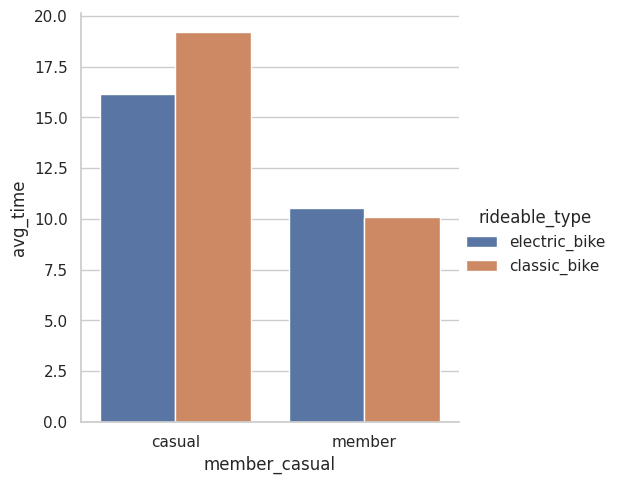

In [ ]:
query = f"""
    SELECT member_casual, rideable_type, AVG(ride_time) as avg_time
    FROM {cleaned_table_ref}
    GROUP BY member_casual, rideable_type
"""

df = client.query(query).to_dataframe()

sns.set_theme(style="whitegrid")
sns.catplot(data=df, kind='bar', x='member_casual', y='avg_time', hue='rideable_type')

In [ ]:
query = f"""
    WITH classic_time AS (
        SELECT rideable_type, ride_time
        FROM {cleaned_table_ref}
        WHERE member_casual = 'casual' AND rideable_type = 'classic_bike' AND RAND() < 0.1
        LIMIT 50000
    ),

    electric_time AS (
        SELECT rideable_type, ride_time
        FROM {cleaned_table_ref}
        WHERE member_casual = 'casual' AND rideable_type = 'electric_bike' AND RAND() < 0.1
        LIMIT 50000
    )

    SELECT * FROM classic_time
    UNION ALL SELECT * FROM electric_time
"""

df = client.query(query).to_dataframe()

classic_bike_time = df[df['rideable_type'] == 'classic_bike']
electric_bike_time = df[df['rideable_type'] == 'electric_bike']

/home/olshe/pers/eu-climate-economic-resilience/.venv/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1957: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


In [150]:
classic_bike_time.describe()

,ride_time
count,50000.0
mean,18.35092
std,15.376798
min,1.0
25%,8.0
50%,14.0
75%,24.0
max,120.0


In [151]:
electric_bike_time.describe()

,ride_time
count,50000.0
mean,15.08814
std,14.276347
min,1.0
25%,6.0
50%,11.0
75%,19.0
max,120.0


In [152]:
ttest_ind(classic_bike_time['ride_time'], electric_bike_time['ride_time'], equal_var=False, alternative='greater')

TtestResult(statistic=np.float64(34.7710802371272), pvalue=np.float64(1.2819316514161793e-263), df=np.float64(99451.6436162839))

In [214]:
query = f"""
    WITH classic_time AS (
        SELECT rideable_type, ride_time
        FROM {cleaned_table_ref}
        WHERE member_casual = 'member' AND rideable_type = 'classic_bike' AND RAND() < 0.1
        LIMIT 50000
    ),

    electric_time AS (
        SELECT rideable_type, ride_time
        FROM {cleaned_table_ref}
        WHERE member_casual = 'member' AND rideable_type = 'electric_bike' AND RAND() < 0.1
        LIMIT 50000
    )

    SELECT * FROM classic_time
    UNION ALL SELECT * FROM electric_time
"""

df = client.query(query).to_dataframe()

member_classic_time = df[df['rideable_type'] == 'classic_bike']
member_electric_time = df[df['rideable_type'] == 'electric_bike']

/home/olshe/pers/eu-climate-economic-resilience/.venv/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1957: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


In [215]:
ttest_ind(member_classic_time['ride_time'], member_electric_time['ride_time'], equal_var=False)

TtestResult(statistic=np.float64(6.238497888662734), pvalue=np.float64(4.4356708690172875e-10), df=np.float64(99242.63003979741))

In [156]:
mean_member = classic_bike_time['ride_time'].mean()
mean_casual = electric_bike_time['ride_time'].mean()

std_member = classic_bike_time['ride_time'].std(ddof=1)
std_casual = electric_bike_time['ride_time'].std(ddof=1)

n_member = len(classic_bike_time['ride_time'])
n_casual = len(electric_bike_time['ride_time'])

pooled_std = np.sqrt(
    ((n_member - 1) * std_member**2 + (n_casual - 1) * std_casual**2) / (n_member + n_casual - 2)
)

cohen_d = (mean_casual - mean_member) / pooled_std
print(f"Cohen's d: {cohen_d}")


Cohen's d: 0.1083899055863786


In [ ]:
query = f"""
    SELECT EXTRACT(HOUR FROM started_at) as hour, AVG(ride_time) as avg_ride_time
    FROM {cleaned_table_ref}
    GROUP BY hour
"""

df = client.query(query).to_dataframe()
df.sort_values(by='hour').plot.bar(x='hour', y='avg_ride_time')